In [0]:
import os
import time
import pandas as pd
import numpy as np
import nltk
import pickle
import json
import sys
sys.setrecursionlimit(10000000)
import re ### to use extended regex library: https://pypi.org/project/regex/
import ast
import csv
from bs4 import BeautifulSoup
import requests
import getpass
from urllib.request import urlopen

!pip install --ignore-installed --index-url https://test.pypi.org/simple/ --no-deps sddk ### our own package under construction, always install to have up-to-date version
import sddk

Looking in indexes: https://test.pypi.org/simple/


# sciencedata.dk configuration

As a data storage, we will use Danish official infrastructure called sciencedata.dk. It is commobly approacheble from any European research institution.

The configuration require having already a proper username and password configurated on the web interface of the platform.

In [0]:
s, sciencedata_groupurl = sddk.configure_session_and_url()

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
sciencedata.dk group folder (ask group owner): direct_root
endpoint for your group (variable 'sciencedata_groupurl') has been configured to: https://sciencedata.dk/files/direct_root/


In [0]:
### if there isn't yer, we will create subfolder for our project 
### otherwise skip!
try:
  s.get(sciencedata_groupurl + "dirgot_data")
except:
  s.request("MKCOL", sciencedata_groupurl + "dirgot_data") 

# Saying verses from colored gospel version

We  use a HTML New Testament with all Jesus' words marked in red. We  extract verse numbers for all these passages. We build a dictionary in the following form

```
saying_verses = {"matt" : ["1.7", "2.12", "11.5"], "mark" : [...], ...}
```



In [0]:
saying_verses = {}
main_url = "https://wn.elib.com/Library/Religious/KJV/NR/NewTrl_"
for gospel in ["matt", "mark", "luke", "john"]:
  response = requests.get(main_url + gospel + ".html")
  soup = BeautifulSoup(response.content, "html.parser")
  soup_saying_verses = []
  for saying in soup.find_all("font", color="#880000"):
    try:
      verse_number = saying.parent.b.get_text()
      if re.match("\d*:\d*", verse_number): ## if it has a form of 11:11? 
        soup_saying_verses.append(verse_number.replace(":", "."))
    except:
      pass
  saying_verses.update({gospel : soup_saying_verses})

In [0]:
### export the data to sciencedata.dk:
s.put(sciencedata_groupurl + "dirgot_data/saying_verses.json", data=json.dumps(saying_verses))

<Response [204]>

In [0]:
### import the data back
saying_verses = json.loads(s.get(sciencedata_groupurl + "dirgot_data/saying_verses.json").content)
saying_verses.keys()

dict_keys(['matt', 'mark', 'luke', 'john'])

# RSV synopis

We will use this source: http://sites.utoronto.ca/religion/synopsis/

Copyrights

The copyright to the RSV is held by the National Council of Churches of Christ.
The copyright to Lambdin's translation of the Gospel of Thomas is held by E.J. Brill.

The copyright to the original markup of this edition of these texts is held by John W. Marshall. The HTML markup is not insubstantial in this case; it forms approximately ¾ of the data within the HTML presentation of the Five Gospels.

These texts are presented for educational purposes only and are not an adequate substitute for printed editions.



In [0]:
#### exctracting the canonical gospels verse by verse

url_form = "http://sites.utoronto.ca/religion/synopsis/"
gospels_data = {}
for gospel in ["gmt", "gmk", "glk", "gjn"]: 
  page = urlopen(url_form + gospel + ".htm")
  soup = BeautifulSoup(page, "html.parser")
  aaas = soup.find_all("a")
  content = []
  for a in aaas:
    a_text = a.get_text()
    a_text_cleaned = a_text.partition('\n')[0].rstrip().replace("\\", "")
    if len(a_text_cleaned) > 0:
      verse_tup = (a_text_cleaned.partition(" ")[0], a_text_cleaned.partition(" ")[2])
      if len(verse_tup[0]) == 0: 
        match = re.findall(r'(\d+\.\d+)(.+)', verse_tup[1]) ### there was a problem in parsing Mark, having a little bit different data structure
        try:
          verse_tup = match[0]
        except:
          pass
      content.append(verse_tup)
  gospels_data.update({gospel : content})

In [0]:
#### ectracting verses containing Jesus' sayings

gospels_sayings = {}
for gospel_pair in zip(["gmt", "gmk", "glk", "gjn"], ["matt", "mark", "luke", "john"]):
  gospel_saying_verses = []
  for verse in gospels_data[gospel_pair[0]]:
    if verse[0] in saying_verses[gospel_pair[1]]:
      gospel_saying_verses.append(verse)
  gospels_sayings.update({gospel_pair[1] : gospel_saying_verses})

[('1.15',
  'and saying, "The time is fulfilled, and the kingdom of God is at hand; repent, and believe in the gospel."'),
 ('1.17',
  'And Jesus said to them, "Follow me and I will make you become fishers of men."'),
 ('1.25', 'But Jesus rebuked him, saying, "Be silent, and come out of him!"'),
 ('1.38',
  'And he said to them, "Let us go on to the next towns, that I may preach there also; for that is why I came out."'),
 ('1.41',
  'Moved with pity, he stretched out his hand and touched him, and said to him, "I will; be clean."'),
 ('1.44',
  'and said to him, "See that you say nothing to any one; but go, show yourself to the priest, and offer for your cleansing what Moses commanded, for a proof to the people."'),
 ('2.5',
  'And when Jesus saw their faith, he said to the paralytic, "My son, your sins are forgiven."'),
 ('2.8',
  'And immediately Jesus, perceiving in his spirit that they thus questioned within themselves, said to them, "Why do you question thus in your hearts?'),
 ('

In [0]:
#### export verses containing Jesus' sayings
s.put(sciencedata_groupurl + "gospels_sayings_raw.json", data=json.dumps(gospels_sayings))

<Response [204]>

In [0]:
##### cleaning the sayings....
gospels_sayings = json.loads(s.get(sciencedata_groupurl + "gospels_sayings_raw.json").content)
gospels_sayings.keys()

dict_keys(['matt', 'mark', 'luke', 'john'])

In [0]:
saying_verses["mark"][:10]

['1.15', '1.17', '1.25', '1.38', '1.41', '1.44', '2.5', '2.8', '2.9', '2.10']

In [0]:
gospels_sayings["mark"][:10]

[['1.15',
  'and saying, "The time is fulfilled, and the kingdom of God is at hand; repent, and believe in the gospel."'],
 ['1.17',
  'And Jesus said to them, "Follow me and I will make you become fishers of men."'],
 ['1.25', 'But Jesus rebuked him, saying, "Be silent, and come out of him!"'],
 ['1.38',
  'And he said to them, "Let us go on to the next towns, that I may preach there also; for that is why I came out."'],
 ['1.41',
  'Moved with pity, he stretched out his hand and touched him, and said to him, "I will; be clean."'],
 ['1.44',
  'and said to him, "See that you say nothing to any one; but go, show yourself to the priest, and offer for your cleansing what Moses commanded, for a proof to the people."'],
 ['2.5',
  'And when Jesus saw their faith, he said to the paralytic, "My son, your sins are forgiven."'],
 ['2.8',
  'And immediately Jesus, perceiving in his spirit that they thus questioned within themselves, said to them, "Why do you question thus in your hearts?'],
 ['

In [0]:
for verse_tup in gospels_sayings["matt"]:
  if verse_tup[1].count("\"") > 2:
    print(verse_tup[1])

But that you may know that the Son of man has authority on earth to forgive sins" --he then said to the paralytic--"Rise, take up your bed and go home."
When he entered the house, the blind men came to him; and Jesus said to them, "Do you believe that I am able to do this?" They said to him, "Yes, Lord."
"Have you understood all this?" They said to him, "Yes."
And Jesus said to them, "How many loaves have you?" They said, "Seven, and a few small fish."
He said, "Yes." And when he came home, Jesus spoke to him first, saying, "What do you think, Simon? From whom do kings of the earth take toll or tribute? From their sons or from others?"
And when he said, "From others," Jesus said to him, "Then the sons are free.
He said to him, "Which?" And Jesus said, "You shall not kill, You shall not commit adultery, You shall not steal, You shall not bear false witness,
And he said to her, "What do you want?" She said to him, "Command that these two sons of mine may sit, one at your right hand and o

In [0]:
len(gospels_sayings["luke"])

578

In [0]:
### the biggest problem is with verses containing more than two quotation marks
### here we use manual input to decide for each individual case
testing_sayings = []  
for verse_tup in gospels_sayings["mark"]:
  if verse_tup[1].count("\"") > 2:
    try:
      found = re.findall(r'(.+)?(\".+\")(.+)(\".+)', verse_tup[1])
      to_decide = found[0]
    except:
      found = re.findall(r'(.+\")(.+)(\".+)', verse_tup[1])
      to_decide = ("", found[0][0], found[0][1], found[0][2])
    if "Jesus" in to_decide[0]:
      testing_sayings.append(to_decide[1])
    else:
      if "Jesus" in to_decide[2]:
        testing_sayings.append(to_decide[3])
      else:
        print(to_decide)
        manual_decision = input("please decide manually which are the sayings ('0,1,2,3'): ")
        if len(manual_decision) == 1:
          testing_sayings.append(to_decide[int(manual_decision)])
        else:
          for each_member in manual_decision.split(","):
            testing_sayings.append(to_decide[int(each_member)])

('Taking her by the hand he said to her, ', '"Tal\'itha cu\'mi"', '; which means, ', '"Little girl, I say to you, arise."')
please decide manually which are the sayings ('0,1,2,3'): 1,3
('But he answered them, ', '"You give them something to eat."', ' And they said to him, ', '"Shall we go and buy two hundred denarii worth of bread, and give it to them to eat?"')
please decide manually which are the sayings ('0,1,2,3'): 1
('And he said to them, ', '"How many loaves have you? Go and see."', ' And when they had found out, they said, ', '"Five, and two fish."')
please decide manually which are the sayings ('0,1,2,3'): 1
('and looking up to heaven, he sighed, and said to him, ', '"Eph\'phatha,"', ' that is, ', '"Be opened."')
please decide manually which are the sayings ('0,1,2,3'): 1,3
('And he asked them, ', '"How many loaves have you?"', ' They said, ', '"Seven."')
please decide manually which are the sayings ('0,1,2,3'): 1
('', 'When I broke the five loaves for the five thousand, how m

In [0]:
gospels_saying_verses = {}   
for gospel in ["matt", "mark", "luke", "john"]:
  sayings = []
  for verse_tup in gospels_sayings[gospel]:
    if verse_tup[1].count("\"") > 2:
      try:
        found = re.findall(r'(.+)?(\".+\")(.+)(\".+)', verse_tup[1])
        to_decide = found[0]
      except:
        found = re.findall(r'(.+\")(.+)(\".+)', verse_tup[1])
        to_decide = ("", found[0][0], found[0][1], found[0][2])
      if "Jesus" in to_decide[0]:
        sayings.append(to_decide[1])
      else:
        if "Jesus" in to_decide[2]:
          sayings.append(to_decide[3])
        else:
          print(to_decide)
          manual_decision = input("please decide manually which are the sayings ('0,1,2,3'): ")
          if len(manual_decision) == 1:
            sayings.append(to_decide[int(manual_decision)])
          else:
            for each_member in manual_decision.split(","):
              sayings.append(to_decide[int(each_member)])
    else:
      if verse_tup[1].count("\"") == 0:
        sayings.append(verse_tup[1])
      else:  
        found = re.findall(r'\".+\"', verse_tup[1])
        if len(found) > 0:
          sayings.append(found[0]) ### found[0][1]
        else: 
          found = re.findall(r" \".+", verse_tup[1])
          if len(found) > 0:
            sayings.append(found[0])
          else:
            found = re.findall(r".+\"", verse_tup[1])
            if len(found) > 0:
              sayings.append(found[0])
            else:
              found = re.findall(r"\".+", verse_tup[1])
              if len(found) > 0:
                sayings.append(found[0])
  gospels_saying_verses.update({gospel : sayings})

('', 'But that you may know that the Son of man has authority on earth to forgive sins"', ' --he then said to the paralytic--', '"Rise, take up your bed and go home."')
please decide manually which are the sayings ('0,1,2,3'): 3
('', '"Have you understood all this?"', ' They said to him, ', '"Yes."')
please decide manually which are the sayings ('0,1,2,3'): 1
('And he said to her, ', '"What do you want?"', ' She said to him, ', '"Command that these two sons of mine may sit, one at your right hand and one at your left, in your kingdom."')
please decide manually which are the sayings ('0,1,2,3'): 1
('They said, ', '"Caesar\'s."', ' Then he said to them, ', '"Render therefore to Caesar the things that are Caesar\'s, and to God the things that are God\'s."')
please decide manually which are the sayings ('0,1,2,3'): 3
('saying, ', '"What do you think of the Christ? Whose son is he?"', ' They said to him, ', '"The son of David."')
please decide manually which are the sayings ('0,1,2,3'): 1
(

In [0]:
gospels_saying_verses[""]

In [0]:
### small update (see the last two rows above)
john_sayings_update = []
for element in gospels_saying_verses["john"]:
  if "he said to him, \"Simon,"  in element:
    john_sayings_update.append("Simon, son of John, do you love me?")
  else:
    john_sayings_update.append(element)
###test:
for element in john_sayings_update:
  if "Simon, son of John, do you" in element:
    print(element)

In [0]:
gospels_saying_verses.update({"john": john_sayings_update})

In [0]:
s.put(sciencedata_groupurl + "dirgot_data/gospels_saying_verses.json", data=json.dumps(gospels_saying_verses))

<Response [204]>

In [0]:
gospels_saying_verses = json.loads(s.get(sciencedata_groupurl + "dirgot_data/gospels_saying_verses.json").content)

# Gospel of Thomas

In [0]:
### the Gospel of Thomas has a little bit different HTML structure, and therefore has to be parsed by sligthly different script
page = urlopen(url_form + "gth" + ".htm")
soup = BeautifulSoup(page, "html.parser")
gth_data_raw = []
for element in soup.get_text().split("\n"):
  saying = element.rstrip().replace("\\", "")
  if len(saying) > 0:
    saying = (saying.partition(") ")[0], saying.partition(") ")[2])
    gth_data_raw.append(saying)
gth_data[:5]

[('The Gospel of Thomas', ''),
 ('The Gospel of Thomas', ''),
 (' Incipit   These are the secret sayings which the living Jesus spoke and which Didymos Judas Thomas wrote down.',
  ''),
 ('  1',
  '  And He said, "Whoever finds the interpretation of these sayings will not experience death."'),
 ('  2',
  '  Jesus said, "Let him who seeks continue seeking until he finds. When he finds, he will become troubled. When he becomes troubled, he will be astonished, and he will rule over the All."')]

In [0]:
gth_data = []
for i in range(3, len(gth_data_raw) - 1):
  if re.match(" \d*", gth_data_raw[i][0]):
    if ")" in gth_data_raw[i][0]:
      gth_data.append((gth_data_raw[i][0].replace(")", "")[2:], gth_data_raw[i + 1][0] + " " + gth_data_raw[i + 2][0]))
    else:
      gth_data.append((gth_data_raw[i][0][2:], gth_data_raw[i][1]))
gth_data_cleaned[:10]

[('1',
  '  And He said, "Whoever finds the interpretation of these sayings will not experience death."'),
 ('2',
  '  Jesus said, "Let him who seeks continue seeking until he finds. When he finds, he will become troubled. When he becomes troubled, he will be astonished, and he will rule over the All."'),
 ('3',
  '  Jesus said, "If those who lead you say, \'See, the Kingdom is in the sky,\' then the birds of the sky will precede you. If they say to you, \'It is in the sea,\' then the fish will precede you. Rather, the Kingdom is inside of you, and it is outside of you. When you come to know yourselves, then you will become known, and you will realize that it is you who are the sons of the living Father. But if you will not know yourselves, you dwell in poverty and it is you who are that poverty."'),
 ('4',
  '  Jesus said, "The man old in days will not hesitate to ask a small child seven days old about the place of life, and he will live. For many who are first will become last, and t

In [0]:
### export the data for extracting Jesus' sayings manually:
s.put(sciencedata_groupurl + "dirgot_data/gth.json", data=json.dumps(gth_data_cleaned))

<Response [201]>

In [0]:
### read back the manually cleaned data:
gth_sayings = ast.literal_eval(s.get(sciencedata_groupurl + "dirgot_data/gth_sayings_manually.txt").text)
gth_sayings[:5]

['Whoever finds the interpretation of these sayings will not experience death.',
 'Let him who seeks continue seeking until he finds. When he finds, he will become troubled. When he becomes troubled, he will be astonished, and he will rule over the All.',
 "If those who lead you say, 'See, the Kingdom is in the sky,' then the birds of the sky will precede you. If they say to you, 'It is in the sea,' then the fish will precede you. Rather, the Kingdom is inside of you, and it is outside of you. When you come to know yourselves, then you will become known, and you will realize that it is you who are the sons of the living Father. But if you will not know yourselves, you dwell in poverty and it is you who are that poverty.",
 'The man old in days will not hesitate to ask a small child seven days old about the place of life, and he will live. For many who are first will become last, and they will become one and the same.',
 'Recognize what is in your sight, and that which is hidden from yo

In [0]:
WordNetLemmatizer() ### used by Mauricio and Nicolas...

# Jesus' sayings in GNT



This might be superuseful at some point in the future:

http://jonathanrobie.biblicalhumanities.org/assets/greeksyntax-tutorial.html

And this too:
https://raw.githubusercontent.com/proiel/proiel-treebank/master/greek-nt.xml"


In [0]:
### uploading the data from github
GNT_df = pd.read_csv("https://raw.githubusercontent.com/biblicalhumanities/Nestle1904/master/morph/Nestle1904.csv", delim_whitespace=True, index_col=False, skiprows=1, names=("book", "ch_v", "func_morph", "pos1", "pos2", "strong", "lemma", "normalized"))
GNT_df.head(5)

### to get the data back from our own storage, uncomment  following command:
### GNT_df = pd.DataFrame(s.get(sciencedata_groupurl + "dirgot_data/GNT_df.json").json())

,book,ch_v,func_morph,pos1,pos2,strong,lemma,normalized
0,Matt,1:1,Βίβλος,N-NSF,N-NSF,976,βίβλος,Βίβλος
1,Matt,1:1,γενέσεως,N-GSF,N-GSF,1078,γένεσις,γενέσεως
2,Matt,1:1,Ἰησοῦ,N-GSM,N-GSM,2424,Ἰησοῦς,Ἰησοῦ
3,Matt,1:1,Χριστοῦ,N-GSM,N-GSM,5547,Χριστός,Χριστοῦ
4,Matt,1:1,υἱοῦ,N-GSM,N-GSM,5207,υἱός,υἱοῦ


In [0]:
GNT_df["ch_v"] = GNT_df["ch_v"].str.replace(":", ".")
GNT_df.head(5)

,book,ch_v,func_morph,pos1,pos2,strong,lemma,normalized
0,Matt,1.1,Βίβλος,N-NSF,N-NSF,976,βίβλος,Βίβλος
1,Matt,1.1,γενέσεως,N-GSF,N-GSF,1078,γένεσις,γενέσεως
2,Matt,1.1,Ἰησοῦ,N-GSM,N-GSM,2424,Ἰησοῦς,Ἰησοῦ
3,Matt,1.1,Χριστοῦ,N-GSM,N-GSM,5547,Χριστός,Χριστοῦ
4,Matt,1.1,υἱοῦ,N-GSM,N-GSM,5207,υἱός,υἱοῦ


In [0]:
GNT_df["book"] = GNT_df["book"].str.lower()

In [0]:
### to do below some matching, we have to take care of appropriate encoding
from unicodedata import normalize
GNT_df["normalized_NFC"] = GNT_df.apply(lambda row: normalize("NFC", row["normalized"]).lower(), axis=1)

In [0]:
### there is also an useful dataset concerning "reported speeches" in the GNT
soup = BeautifulSoup(requests.get("https://raw.githubusercontent.com/biblicalhumanities/levinsohn/master/LGNTDF/Reported_Speech.xml").content)
### using it, we can identify some words in verses containing Jesus' own words
soup.find_all("reference", attrs={"verse" : "MAT" + " " + "3:15"})[0].get_text()

'ἄφες ἄρτι οὕτως γὰρ πρέπον ἐστὶν ἡμῖν πληρῶσαι πᾶσαν δικαιοσύνην'

In [0]:
raw_saying_list = [normalize("NFC", word) for word in soup.find_all("reference", attrs={"verse" : "MAT" + " " + "3:15"})[0].get_text().split()]
raw_saying_list

['ἄφες',
 'ἄρτι',
 'οὕτως',
 'γὰρ',
 'πρέπον',
 'ἐστὶν',
 'ἡμῖν',
 'πληρῶσαι',
 'πᾶσαν',
 'δικαιοσύνην']

In [0]:
verse_df = GNT_df[(GNT_df["book"]=="matt") & (GNT_df["ch_v"]=="3.15") ]
saying_df = verse_df.loc[verse_df['normalized_NFC'].isin(raw_saying_list)]
saying_df

,book,ch_v,func_morph,pos1,pos2,strong,lemma,normalized,normalized_NFC
1166,matt,3.15,Ἄφες,V-2AAM-2S,V-2AAM-2S,863&5628,ἀφίημι,Ἄφες,ἄφες
1167,matt,3.15,ἄρτι·,ADV,ADV,737,ἄρτι,ἄρτι,ἄρτι
1168,matt,3.15,οὕτως,ADV,ADV,3779,οὕτω,οὕτως,οὕτως
1170,matt,3.15,πρέπον,V-PAP-NSN,V-PAP-NSN,4241&5723,πρέπω,πρέπον,πρέπον
1172,matt,3.15,ἡμῖν,P-1DP,P-1DP,1473,ἐγώ,ἡμῖν,ἡμῖν
1173,matt,3.15,πληρῶσαι,V-AAN,V-AAN,4137&5658,πληρόω,πληρῶσαι,πληρῶσαι
1174,matt,3.15,πᾶσαν,A-ASF,A-ASF,3956,πᾶς,πᾶσαν,πᾶσαν
1175,matt,3.15,δικαιοσύνην.,N-ASF,N-ASF,1343,δικαιοσύνη,δικαιοσύνην,δικαιοσύνην


In [0]:
saying_lemmata = saying_df[saying_df["pos1"].str.startswith(("N", "A", "V"))]["lemma"].tolist()
saying_lemmata

['ἀφίημι', 'ἄρτι', 'οὕτω', 'πρέπω', 'πληρόω', 'πᾶς', 'δικαιοσύνη']

In [0]:
### main function. Still space for improvement....
%%time
GNT_sayings = {}
for gospel_tup in zip(["MAT", "MRK", "LUK", "JHN"], ["matt", "mark", "luke", "john"]):
  gospels_sayings_dict = dict(gospels_sayings[gospel_tup[1]])
  saying_verse_texts = []
  for saying_verse in saying_verses[gospel_tup[1]]:
    saying_verse_text = []
    for tag in soup.find_all("reference", attrs={"verse" : gospel_tup[0] + " " + saying_verse.replace(".", ":")}):
      saying_verse_text.append(tag.get_text())
    verse_df = GNT_df[(GNT_df["book"]==gospel_tup[1]) & (GNT_df["ch_v"]==saying_verse)]
    if len(saying_verse_text) == 0:
      saying_df = verse_df
    if len(saying_verse_text) == 1:
      saying_verse_text = saying_verse_text[0].split()
      raw_saying_list = [normalize("NFC", word) for word in saying_verse_text]
      saying_df = verse_df.loc[verse_df['normalized_NFC'].isin(raw_saying_list)]
    if len(saying_verse_text) > 1:
      raw_saying_list = [normalize("NFC", word) for word in saying_verse_text]
      saying_df = verse_df.loc[verse_df['normalized_NFC'].isin(raw_saying_list)]
    saying_lemmata = saying_df[saying_df["pos1"].str.startswith(("N", "A", "V"))]["lemma"].tolist()
    try:
      english_verse = gospels_sayings_dict[saying_verse]
    except:
      english_verse = "not found"
    saying_verse_texts.append((saying_verse, saying_lemmata, english_verse))
  GNT_sayings.update({gospel_tup[1] : saying_verse_texts})

CPU times: user 58.5 s, sys: 10.4 ms, total: 58.5 s
Wall time: 58.6 s


In [0]:
GNT_sayings["matt"][:10]

[('3.15',
  ['ἀποκρίνομαι',
   'Ἰησοῦς',
   'λέγω',
   'ἀφίημι',
   'ἄρτι',
   'οὕτω',
   'πρέπω',
   'εἰμί',
   'πληρόω',
   'πᾶς',
   'δικαιοσύνη',
   'τότε',
   'ἀφίημι'],
  'But Jesus answered him, "Let it be so now; for thus it is fitting for us to fulfil all righteousness." Then he consented.'),
 ('4.4',
  ['ἀποκρίνομαι',
   'λέγω',
   'γράφω',
   'ἄρτος',
   'μόνος',
   'ζάω',
   'ἄνθρωπος',
   'πᾶς',
   'ῥῆμα',
   'ἐκπορεύομαι',
   'στόμα',
   'θεός'],
  'But he answered, "It is written, \'Man shall not live by bread alone, but by every word that proceeds from the mouth of God.\'"'),
 ('4.7',
  ['φημί', 'Ἰησοῦς', 'πάλιν', 'γράφω', 'ἐκπειράζω', 'κύριος', 'θεός'],
  'Jesus said to him, "Again it is written, \'You shall not tempt the Lord your God.\'"'),
 ('4.10',
  ['τότε',
   'λέγω',
   'Ἰησοῦς',
   'ὑπάγω',
   'Σατανᾶς',
   'γράφω',
   'κύριος',
   'θεός',
   'προσκυνέω',
   'μόνος',
   'λατρεύω'],
  'Then Jesus said to him, "Begone, Satan! for it is written, \'You shall worshi

In [0]:
def object_to_file(file_name_and_loc, python_object):
  if s.get(sciencedata_groupurl + file_name_and_loc).ok: ### if there already is a file with the same name
    new_name = input("file with name \"" + file_name_and_loc.rpartition("/")[2] + "\" already exists in given location. Press Enter to overwrite it or enter a different name (without path)")
    if len(new_name) == 0:
      s.put(sciencedata_groupurl + file_name_and_loc, data=json.dumps(python_object))
    else:
      if "/" in new_name: ### if it is a path
        s.put(sciencedata_groupurl + new_name, data=json.dumps(python_object))
      else: 
        s.put(sciencedata_groupurl + file_name_and_loc.rpartition("/")[0] + new_name, data=json.dumps(python_object))
  else:
    s.put(sciencedata_groupurl + file_name_and_loc, data=json.dumps(python_object))

In [0]:
def object_from_file(file_name_and_loc):
  if s.get(sciencedata_groupurl + file_name_and_loc).ok:
    print("file exists")
    try: 
      return json.loads(s.get(sciencedata_groupurl + file_name_and_loc).content) ### if there already is a file with the same name
    except:
      print("file import failed")
  else:
    print("file does not found; check file name and path.")

In [0]:
GNT_sayings = object_from_file("dirgot_data/GNT_sayings.json")

file exists


In [0]:
file_name_and_loc = "dirgot_data/GNT_sayings.json"
data = GNT_sayings

object_to_file(file_name_and_loc, data)

file with name "GNT_sayings.json" already exists in given location. Press Enter to overwrite it or enter a different name (without path)


# OLD STUFF

In [0]:
### function to extract Jesus words from online available Red Letter Editions
### in the html, Jesus' words are tagged by "<font>" with attribute of certain color

def scrape_web(url):
    page = urlopen(url)
    soup = BeautifulSoup(page, "html.parser")
    output = []
    for saying in soup.find_all("font", color="#880000"):
        output.append(" ".join(saying.get_text().split()))
    output = " ".join(output)
    return output

In [0]:
matt_jesus = scrape_web('https://wn.elib.com/Library/Religious/KJV/NR/NewTrl_matt.html')
mark_jesus = scrape_web('https://wn.elib.com/Library/Religious/KJV/NR/NewTrl_mark.html')
luke_jesus = scrape_web('https://wn.elib.com/Library/Religious/KJV/NR/NewTrl_luke.html')
john_jesus = scrape_web('https://wn.elib.com/Library/Religious/KJV/NR/NewTrl_john.html')

In [0]:
### short demonstration of the data
luke_jesus[:100]

"How is it that ye sought me? wist ye not that I must be about my Father's business? It is written, T"

# Gospel of Thomas

In [0]:
file = open("input_data/GoT.txt", "r")
got = file.read()

In [0]:
direct_speechs = regex.findall(r'(.+)(\".+\")', got)
direct_speechs[:3] ### short demonstration

[('And he said, ',
  '"Whoever discovers the meaning of these sayings won\'t taste death."'),
 ('Jesus said, ',
  '"Whoever seeks shouldn\'t stop until they find. When they find, they\'ll be disturbed. When they\'re disturbed, they\'ll be […] amazed, and reign over the All."'),
 ('Jesus said, ',
  '"The older person won\'t hesitate to ask a little seven-day-old child about the place of life, and they\'ll live, because many who are first will be last, and they\'ll become one."')]

In [0]:
thom_jesus_context = []
for element in direct_speechs:
    found = regex.search(r'(\she|He|Jesus)(\s|\b)', element[0])
    if not found == None:
        thom_jesus_context.append(element)

In [0]:
with open("data/thom_jesus.csv", "w") as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(["jesus?", "preceding_sentence", "saying"])
    for row in thom_jesus_context:
        csv_writer.writerow(["", row[0], row[1]])

In [0]:
### upload back the modified data

thom_jesus_selected_df = pd.read_csv("data/thom_jesus_selected.csv")

In [0]:
### select the Jesus's words only, i.e. marked by "y" in the column "Jesus?" 

thom_jesus = thom_jesus_selected_df[thom_jesus_selected_df["jesus?"].str.startswith("y", na=False)]["saying"].tolist()
thom_jesus = " ".join(thom_jesus).replace("\"" , "")
thom_jesus[:100]

"Whoever discovers the meaning of these sayings won't taste death. Whoever seeks shouldn't stop until"

# Frequency Distributions

In [0]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.corpus import stopwords

to_replace= {
### archaisms
    " ye " : " you ",
    " thee " : " you ",
    " thou " : " you ",
    " thy " : " you ",
    "thine" : "yours",
    "shall": "will",
    "shalt": "be",
    " hath" : " have",
    " hast" : " have",
    "hateth" : "hate",
    "cometh" : "come",
    "believeth" : "believe",
    "doeth" : "do", 
    "seeth" : "see",
    "shew" : "show",
    "unto" : "to",
    " men " : " man ",
    "whoever" : "who ever",
    "art" : "be",
    "asketh" : "ask",
    "bringeth" : "bring",
    "calleth" : "call",
    "cannot" : "can not",
    "canst" : "can",
    "commandmants" : "commandmant",
    "committeth" : "commit",
    "dists" : "do",
    "entereth" : "enter",
    "gathereth" : "gather",
    "goeth" : "go",
    "heareth" : "hear",
    "husbandman" : "husband",
    "knewest" : "know",
    "knowest" : "know",
    "knoweth" : "know",
    "leaven" : "yeast",
    "lest" : "", ### highly disturbing
    "loveth" : "love",
    "nigh" : "close",
    "putteth" : "put",
    "receiveth" : "receive",
    "saith" : "say",
    "sayest" : "say",
    "scattereth" : "scatter",
    "seeketh" : "seek",
    "sleepeth" : "sleep",
    "speaketh" : "speak",
    "taketh" : "take",
    "walketh" : "walk",
    "wheresoever" : "",
    "whatsoever" : "",
    "whence" : "",
    "whose" : "",
    "whoso" : "",
    "whereto" : "",
    "whosoever" : "",
    "yea" : "yes",    
### contractions (in the Gospel of Thomas)
    "they'll" : "they will", "that's" : "that is", "who's" : "who is", "what's" : "what is", "i'm" : "i am", "father's" : "father","i've" : "i have", "they're" : "they are", "there's" : "there is"
    }    

def most_frequent(string, number):
    string = regex.sub(r'[^\w\s\']','', string) ### remove punctuation
    for word, key in to_replace.items():
        string = string.lower().replace(word, key)
    string_filtered = [word.lower() for word in string.split() if word.lower() not in stopwords.words('english')]
    string_lemmatized_verbs = []
    ### lemmatize verbs (= "pos="v"")
    for word in string_filtered:
        string_lemmatized_verbs.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    ### lemmatize rest (= substantives from plural to singular)
    string_lemmatized = []
    for word in string_lemmatized_verbs:
        string_lemmatized.append(wordnet_lemmatizer.lemmatize(word))
    ### count frequency distribution
    string_fd = nltk.FreqDist(string_lemmatized)
    string_fd_most_common = string_fd.most_common(number)
    ### normalize frequency distribution
    output = []
    for freq_element in string_fd_most_common:
        output.append((freq_element[0], round(freq_element[1] / len(string_lemmatized), 5)))
    return output

In [0]:
most_frequent(thom_jesus, 50)

[('ever', 0.02597),
 ('one', 0.02516),
 ('become', 0.01867),
 ('find', 0.01542),
 ('know', 0.01542),
 ('come', 0.01461),
 ('father', 0.01299),
 ('look', 0.01055),
 ('world', 0.01055),
 ('kingdom', 0.01055),
 ('hear', 0.00974),
 ('make', 0.00974),
 ('see', 0.00974),
 ('give', 0.00974),
 ('bless', 0.00893),
 ('like', 0.00893),
 ('say', 0.00812),
 ('live', 0.00812),
 ('hide', 0.00812),
 ('heaven', 0.00812),
 ('go', 0.00812),
 ('light', 0.00812),
 ('place', 0.00731),
 ('eye', 0.00731),
 ('person', 0.00649),
 ('reveal', 0.00649),
 ('eat', 0.00649),
 ('compare', 0.00649),
 ('two', 0.00649),
 ('hand', 0.00649),
 ('enter', 0.00649),
 ('little', 0.00568),
 ('child', 0.00568),
 ('ear', 0.00568),
 ('take', 0.00568),
 ('worthy', 0.00568),
 ('human', 0.00487),
 ('anyone', 0.00487),
 ('seed', 0.00487),
 ('someone', 0.00487),
 ('house', 0.00487),
 ('image', 0.00487),
 ('within', 0.00487),
 ('death', 0.00406),
 ('cast', 0.00406),
 ('good', 0.00406),
 ('die', 0.00406),
 ('day', 0.00406),
 ('earth', 0.0

# Visualizing Frequency Distributions

In [0]:
### FUNCTION to generate bar plot
### two arguments: source text, number of words

### the GRAPH is generated by means of Plotly
import plotly.plotly as py ## plots ["plotly" has to be installed, ideally with pip: https://plot.ly/python/getting-started/]
import plotly.graph_objs as go

def norm_fd_graph(text, number):
    FD_df = pd.DataFrame(most_frequent(text, number), columns=["word", "normalized_FD"])

    FD_df.sort_values(by=["normalized_FD"], ascending=True,inplace=True)

    data = [
         go.Bar(
             y=FD_df["word"],
             x=FD_df["normalized_FD"],
             name= "Norm FD of the term in the text",
             orientation = 'h',
             marker=dict(
                color='#990099'
                )
             ),   
    ###go.Bar(
    ###   y=fd_pd_combined["lemma"],
    ###    x=fd_pd_combined["normalized_FD"],
    ###    name= "NormFD of the term in πνεῦμα conc.",
    ###    orientation = 'h'
    ###    ),
    ###go.Bar(
    ###    y=fd_pd_combined["lemma"],
    ###    x=fd_pd_combined["conc_HS"],
    ###    name= "NormFD of the term in πνεῦμα_ἅγιον conc.",
    ###    orientation = 'h',
    ###    ),
    ]

    layout = go.Layout(
        barmode='group',
        title="Norm FD of the term",
        autosize=False,
        width=700,
        height=1000,
        legend=dict(
            x=0.4,
            y=0.05,
            traceorder='reversed',
            font=dict(
                family='sans-serif',
                size=12,
               color='#000'
            ),
        ## bgcolor='#E2E2E2',
        ## bordercolor='#FFFFFF',
        ## borderwidth=2
        )
    )

    fig = go.Figure(data=data, layout=layout)

    return py.iplot(fig, filename='norm_fd')

In [0]:
norm_fd_graph(john_jesus, 30)

# Lemmatization

In [0]:
gospels_jesus_list_raw = [thom_jesus, matt_jesus, mark_jesus, luke_jesus, john_jesus]
gospels_jesus_lemmatized = []

for string in gospels_jesus_list_raw:
    string = regex.sub(r'[^\w\s\']','', string) ### remove punctuation
    for word, key in to_replace.items():
        string = string.lower().replace(word, key)
    string_filtered = [word.lower() for word in string.split() if word.lower() not in stopwords.words('english')]
    string_lemmatized_verbs = []
    ### lemmatize verbs (= "pos="v"")
    for word in string_filtered:
        string_lemmatized_verbs.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    ### lemmatize rest (= substantives from plural to singular)
    string_lemmatized = []
    for word in string_lemmatized_verbs:
        string_lemmatized.append(wordnet_lemmatizer.lemmatize(word))
    gospels_jesus_lemmatized.append(" ".join(string_lemmatized))

In [0]:
with open("data/gospels_jesus_lemmatized.pkl", "wb") as f:
    pickle.dump(gospels_jesus_lemmatized, f)

In [0]:
### to start from here
### UPLOAD the data
file = open("data/gospels_jesus_lemmatized.pkl", "rb")
gospels_jesus_lemmatized = pickle.load(file)

# Vectorization

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
### we transform the list of abbreviations into a document term matrix using
### tool: sklearn CountVectorizer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.

vec = CountVectorizer(min_df = 3)
X = vec.fit_transform(gospels_jesus_lemmatized)
vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
###vectorizazion_df

In [0]:
### to add there the names of authors
gospels_jesus_vec = pd.concat([pd.Series(["thom_jesus", "matt_jesus", "mark_jesus", "luke_jesus", "john_jesus"]), vectorization_df], axis=1)
gospels_jesus_vec.rename(index=str, columns={0 : "gospel"}, inplace=True)
# to save the vectorization data into a csv
gospels_jesus_vec.to_csv("data/gospels_jesus_vec.csv")

In [0]:
gospels_jesus_vec

,gospel,abide,able,abomination,abraham,abroad,abundance,accord,account,adultery,...,world,worse,worship,worthy,would,write,yes,yesst,yet,yoke
0,thom_jesus,0,4,0,0,0,0,0,0,0,...,13,0,1,7,3,0,0,1,1,1
1,matt_jesus,1,6,1,2,2,3,3,2,8,...,15,2,3,8,14,8,4,3,10,2
2,mark_jesus,1,0,1,1,1,1,0,1,4,...,5,1,1,0,1,7,0,2,5,0
3,luke_jesus,2,6,1,10,1,3,2,3,3,...,7,1,2,6,14,14,5,2,11,1
4,john_jesus,13,1,0,6,0,0,1,0,0,...,65,1,7,0,8,6,2,0,21,0


# Distance (inverse cosine similarity)

In [0]:
### INVERSE COSINE SIMILARITY, i.e. DISTANCE
# https://en.wikipedia.org/wiki/Cosine_similarity
# as used here: https://de.dariah.eu/tatom/working_with_text.html#comparing-texts

from sklearn.metrics.pairwise import cosine_similarity
dist_cosine = 1 - cosine_similarity(X.toarray())
dist_cosine_df = pd.DataFrame(np.round(dist_cosine, 5))

distance_matrix_df = pd.concat([gospels_jesus_vec.reset_index(level=[0])["gospel"], dist_cosine_df], axis=1)

distance_matrix_df.drop(["gospel"], axis=1, inplace=True)
distance_matrix_df.columns = ["thom_jesus", "matt_jesus", "mark_jesus", "luke_jesus", "john_jesus"]
distance_matrix_df.index = ["thom_jesus", "matt_jesus", "mark_jesus", "luke_jesus", "john_jesus"]
distance_matrix_df.to_csv("data/gospels_jesus_distance_matrix.csv")
distance_matrix_df

,thom_jesus,matt_jesus,mark_jesus,luke_jesus,john_jesus
thom_jesus,0.00000,0.38603,0.45180,0.42628,0.48681
matt_jesus,0.38603,-0.00000,0.08931,0.05379,0.27287
mark_jesus,0.45180,0.08931,0.00000,0.08204,0.29536
luke_jesus,0.42628,0.05379,0.08204,0.00000,0.26543
john_jesus,0.48681,0.27287,0.29536,0.26543,0.00000


# Plotting Distances

In [0]:
### to transform the distances into a n-dimensional space 
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [0]:
# to have the plot big enough, we will modify default size of all generated plots
# (original is 6 to 4 inches)
plt.rcParams['figure.figsize'] = (18.0, 12.0)

In [0]:
# we need to transform the indovidual distances into a 2-dimensional space
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist_cosine)
xs, ys = pos[:, 0], pos[:, 1]

In [0]:
names = ["thom_jesus", "matt_jesus", "mark_jesus", "luke_jesus", "john_jesus"]

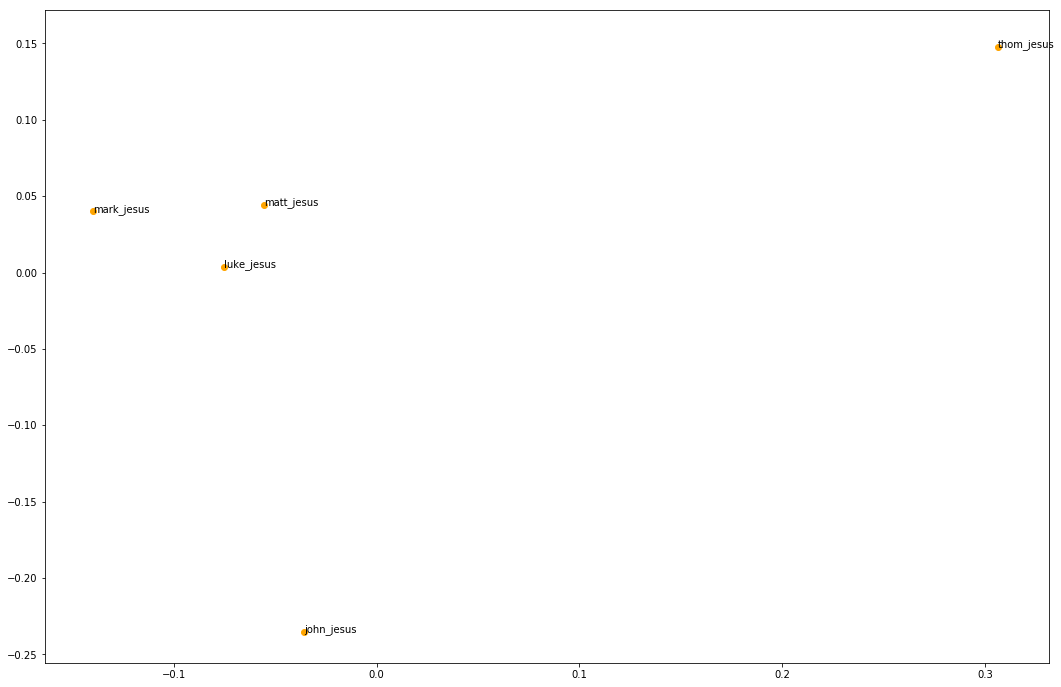

In [0]:
# now we can plot the distances transformed via the mds function as a scatter plot
for x, y, name in zip(xs, ys, names):
    color = "orange"
    plt.scatter(x, y, c=color)
    plt.text(x, y, name)
plt.savefig("data/distances_2d.png")
plt.show()

In [0]:
### we can easily modify the mode for 3D plotting

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist_cosine)

In [0]:
### the plotting can use this tool
from mpl_toolkits.mplot3d import Axes3D

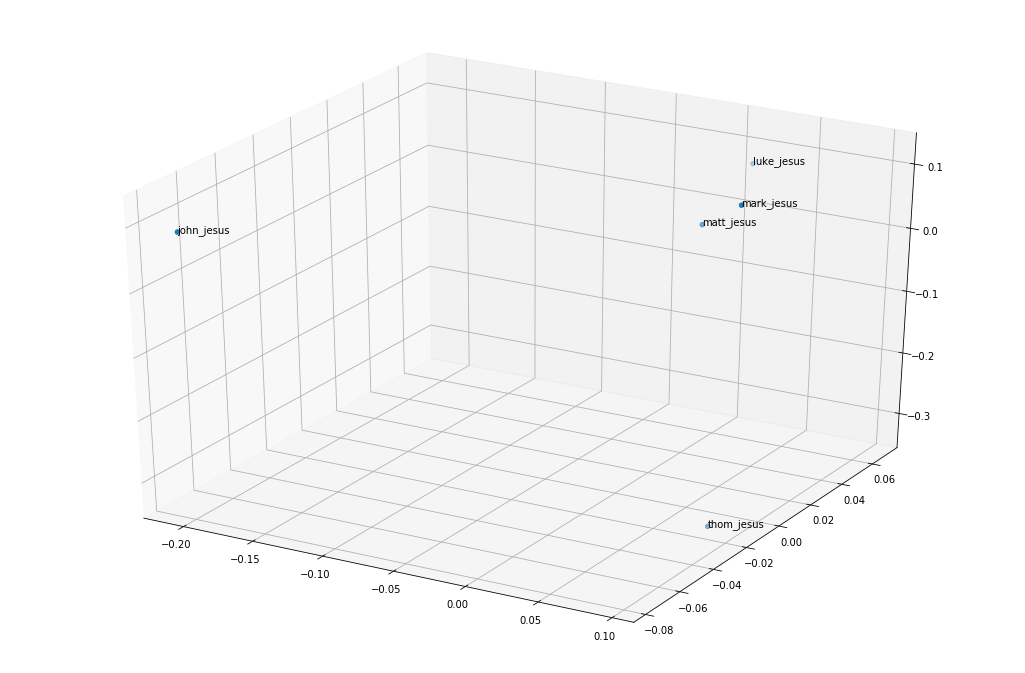

In [0]:
### plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])
for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], names):
    ax.text(x, y, z, s)
plt.savefig("data/distances_3d.png")
plt.show()